# 1-Imports

First, we import necessary packages

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder
import math
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2- Read in Data 

Next, we list the input files to see that there are 6 files available.

In [2]:
weather_train_df = pd.read_csv('./weather_train.csv')
weather_train_df=weather_train_df.iloc[0:1000000]

In [3]:
weather_test_df = pd.read_csv('./weather_test.csv')
weather_test_df=weather_test_df.iloc[0:1000000]

In [4]:
building_meta_df = pd.read_csv('./building_metadata.csv')
building_meta_df=building_meta_df.iloc[0:1000000]

In [5]:

sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission=sample_submission.iloc[0:500000]

In [6]:
train_df = pd.read_csv('./train.csv')
train_df=train_df.iloc[0:1000000]

In [7]:
test_df = pd.read_csv('./test.csv')
test_df=test_df.iloc[0:500000]

In [8]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')


# 3-Glimpse of Data

In [11]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)


Size of train_df data (1000000, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


# 4- Reducing Memory Size

In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
#Reducing memory
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 14.31 Mb (53.1% reduction)
Mem. usage decreased to  6.68 Mb (56.2% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [15]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

In [16]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [17]:
weather_train_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

In [18]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [19]:
weather_test_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

In [20]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [21]:
building_meta_df.columns.values

array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

# 5-Merge Data into 2 datasets: train and test

In [11]:
train = train_df.merge(building_meta_df,on = "building_id",how = "left")

In [13]:
train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,NaN
...,...,...,...,...,...,...,...,...,...
999995,1244,1,2016-01-19 03:00:00,22.929701,14,Public services,95526,NaN,NaN
999996,1244,3,2016-01-19 03:00:00,1050.959961,14,Public services,95526,NaN,NaN
999997,1245,0,2016-01-19 03:00:00,65.656197,14,Healthcare,35354,NaN,NaN
999998,1245,1,2016-01-19 03:00:00,0.000000,14,Healthcare,35354,NaN,NaN


In [12]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

In [13]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])

In [14]:
weather_train_df

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.000000,NaN,-8.000000,NaN,NaN,180.0,5.699219
139769,15,2016-12-31 20:00:00,2.800781,2.0,-8.898438,NaN,1007.5,180.0,7.699219
139770,15,2016-12-31 21:00:00,2.800781,NaN,-7.199219,NaN,1007.5,180.0,5.101562
139771,15,2016-12-31 22:00:00,2.199219,NaN,-6.699219,NaN,1008.0,170.0,4.601562


In [15]:
train =train.merge(weather_train_df, on =["timestamp","site_id"])

In [16]:
test = test_df.merge(building_meta_df,on = "building_id",how = "left")

In [17]:
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [18]:
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [19]:
test = test.merge(weather_test_df, on =["site_id","timestamp"])

In [28]:
test

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499995,98,0,2017-06-11 11:00:00,0,Lodging/residential,200933,2007.0,NaN,22.796875,NaN,22.796875,0.0,1020.0,0.0,0.000000
499996,499996,98,1,2017-06-11 11:00:00,0,Lodging/residential,200933,2007.0,NaN,22.796875,NaN,22.796875,0.0,1020.0,0.0,0.000000
499997,499997,99,0,2017-06-11 11:00:00,0,Office,2260,2016.0,NaN,22.796875,NaN,22.796875,0.0,1020.0,0.0,0.000000
499998,499998,100,0,2017-06-11 11:00:00,0,Lodging/residential,24456,1968.0,NaN,22.796875,NaN,22.796875,0.0,1020.0,0.0,0.000000


In [30]:
test.shape

(500000, 16)

In [31]:
train.shape

(978683, 16)

# 6-Exploratory Data Analysis(EDA)

Here, we will start working with the datasets and try to build some understanding about the same first using certain visualizations. Then we will see if we can do some feature engineering and try to build some model.


In [25]:
train.describe(include='all')

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,978683.000000,978683.000000,978683,9.786830e+05,978683.000000,978683,978683.000000,384847.0,170811.0,977863.000000,504008.0,977810.000000,813319.0,891927.0,934514.0,976622.000000
unique,NaN,NaN,436,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2016-01-15 20:00:00,NaN,NaN,Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2306,NaN,NaN,392386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-01-19 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,803.173542,0.653961,NaN,1.378314e+03,8.041387,NaN,107749.762665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,424.181026,0.934723,NaN,6.692951e+04,5.074614,NaN,116868.961010,NaN,0.0,0.000000,0.0,0.000000,0.0,NaN,NaN,0.000000
min,0.000000,0.000000,NaN,0.000000e+00,0.000000,NaN,283.000000,1900.0,1.0,-25.593750,0.0,-29.406250,-1.0,974.5,0.0,0.000000
25%,400.000000,0.000000,NaN,1.291000e+01,3.000000,NaN,32256.000000,1951.0,1.0,-2.199219,0.0,-8.296875,0.0,1011.5,80.0,2.099609


In [26]:
#Missing data 
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(8)

,Total,Percent
floor_count,807872,82.546851
year_built,593836,60.677053
cloud_coverage,474675,48.501404
precip_depth_1_hr,165364,16.896584
sea_level_pressure,86756,8.864566
wind_direction,44169,4.513106
wind_speed,2061,0.210589
dew_temperature,873,0.089202


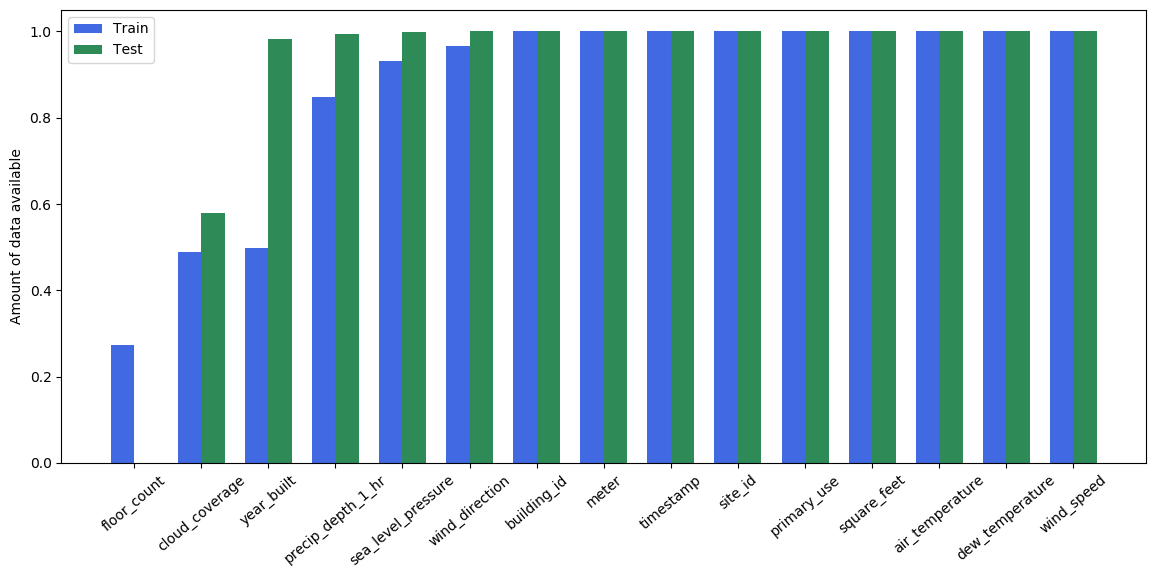

In [33]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

In [ ]:
##floor_count,built,cloud_coverage contains many missing values

In [34]:
#Column Types
train.dtypes

building_id                    int16
meter                           int8
timestamp             datetime64[ns]
meter_reading                float32
site_id                         int8
primary_use                   object
square_feet                    int32
year_built                   float16
floor_count                  float16
air_temperature              float16
cloud_coverage               float16
dew_temperature              float16
precip_depth_1_hr            float16
sea_level_pressure           float16
wind_direction               float16
wind_speed                   float16
dtype: object

In [ ]:
#all the types are int or float, but primary_use is object that's why we should Convert it  to category


In [ ]:
# Let's check the correlation between the variables and eliminate the one's that have high correlation


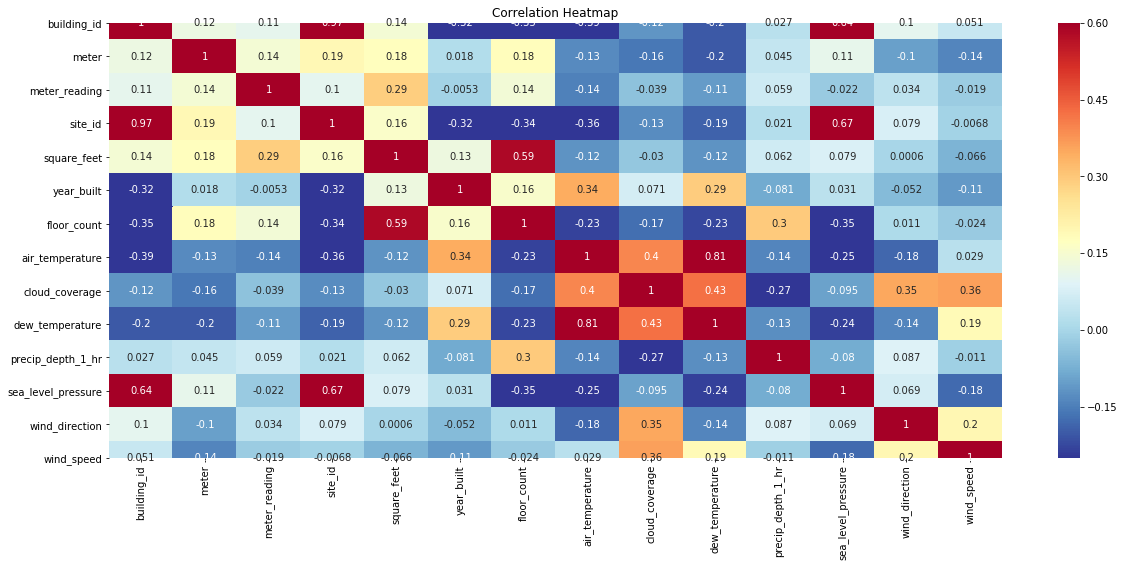

In [35]:
#Correlations
plt.figure(figsize = (20, 8))
correlations = train.corr()
# Heatmap of correlations
sns.heatmap(correlations, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [ ]:
#we notice that the biggest correlation is between 'site_id' and 'building_id' (0.97)
#also we find that air_temerature and dew_tempertaed are corretated.(0.81)
# ==> we  will remove one of them 

In [36]:
# Find correlations with the target and sort
correlations = train.corr()['meter_reading'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(5))
print('\nMost Negative Correlations:\n', correlations.head(5))

Most Positive Correlations:
 building_id      0.106525
floor_count      0.140612
meter            0.144769
square_feet      0.288148
meter_reading    1.000000
Name: meter_reading, dtype: float64

Most Negative Correlations:
 air_temperature      -0.144401
dew_temperature      -0.106231
cloud_coverage       -0.038838
sea_level_pressure   -0.021947
wind_speed           -0.018817
Name: meter_reading, dtype: float64


In [37]:
#we find that the target 'meter_reading' is not very correlated with the others varibales 
#the biggest corelation is with 'square_feet'

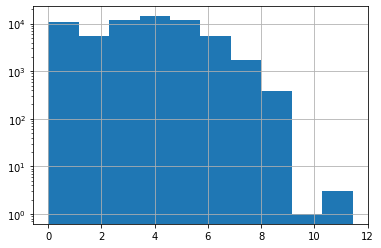

In [39]:
#Distribution of the target:  Meter reading
# target's log-log histogram:
ax = np.log1p(train.meter_reading).hist()
ax.set_yscale('log')

# Features understanding

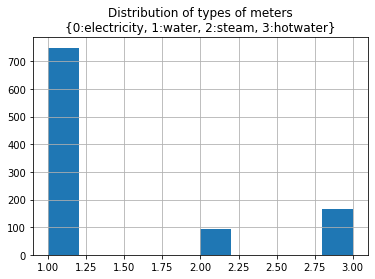

In [40]:
#1-meter
#meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. 
# check the distribution in the types of meters
meters = train.groupby('building_id').meter.nunique()
plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}') 
_ = meters.hist()


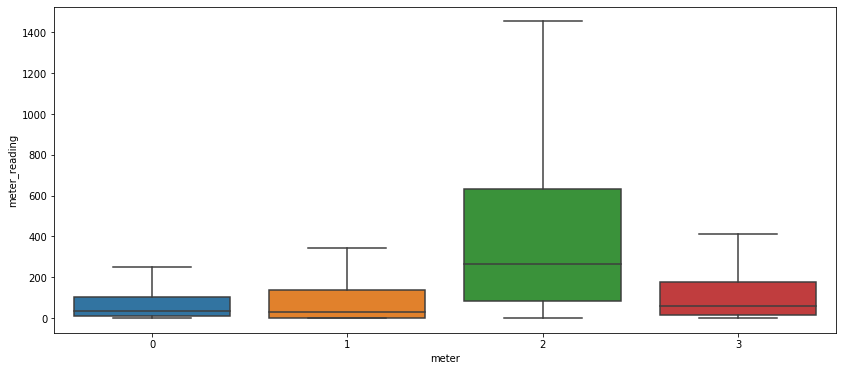

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False)

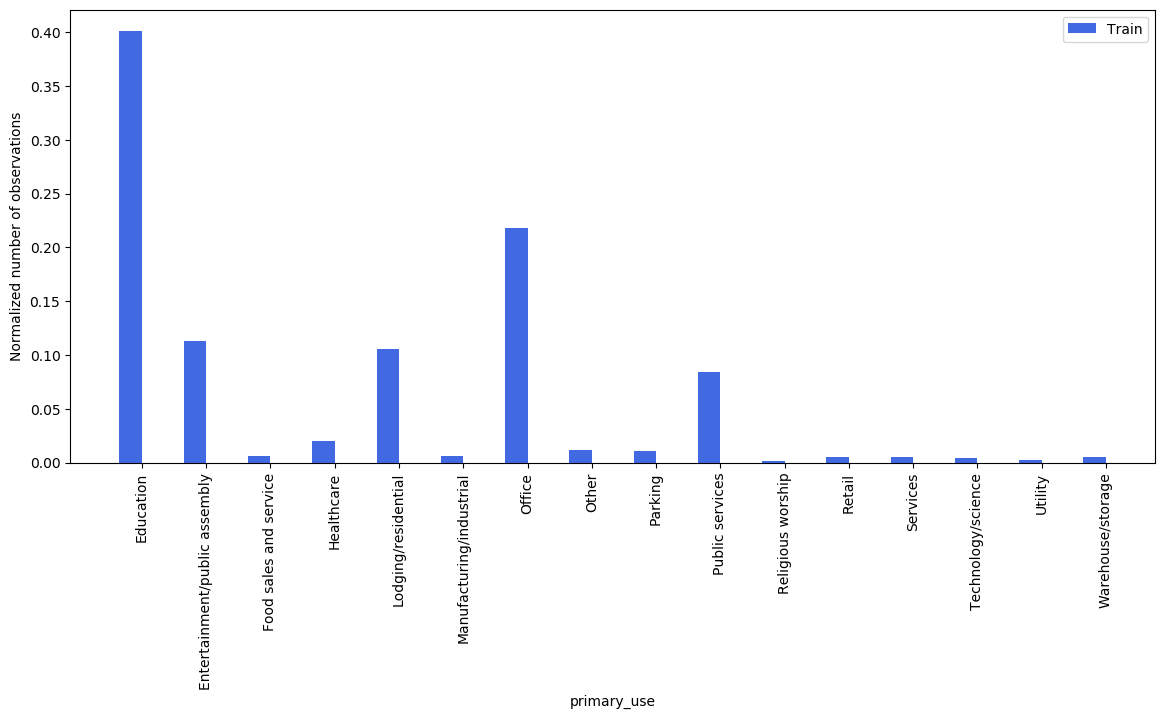

In [21]:
#2-primary_use
#primary_use - Indicator of the primary category of activities for the building 
train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')


axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation=90)


axes.legend([tr], ['Train'], facecolor='white');


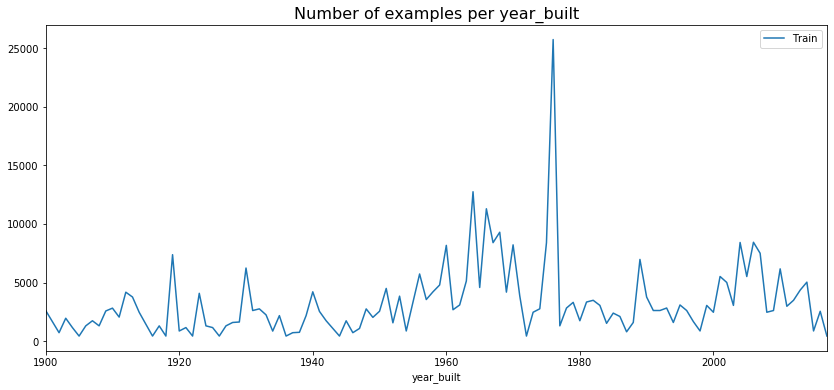

In [22]:
#year_built:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_xlabel('year_built');
axes.legend(['Train']);
axes.set_title('Number of examples per year_built', fontsize=16);

NameError: name 'ax2' is not defined

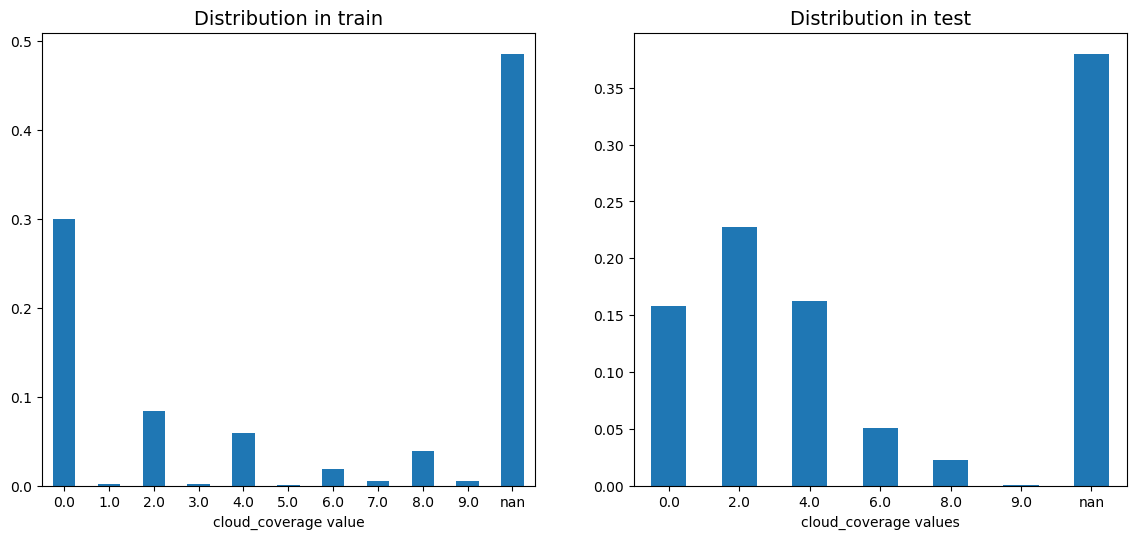

In [27]:
#cloud_coverage - Portion of the sky covered in clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
train['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('cloud_coverage value');
test['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('cloud_coverage values');
axes[0].set_title('Distribution in train', fontsize=14);
axes[1].set_title('Distribution in test', fontsize=14);
train[['cloud_coverage', 'meter_reading']].replace(np.nan, 'nan').groupby('cloud_coverage')['meter_reading'].mean().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
plt.subplots_adjust(wspace=0.4);

# 8-Feature engineering and selection 

In [23]:
#Convert timestamp
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [24]:
train['day'] = train['timestamp'].dt.day
train['weekday'] = train['timestamp'].dt.weekday
train['hour'] = train['timestamp'].dt.hour
train['month'] = train['timestamp'].dt.month

In [25]:
test['day'] = test['timestamp'].dt.day
test['weekday'] = test['timestamp'].dt.weekday
test['hour'] = test['timestamp'].dt.hour
test['month'] = test['timestamp'].dt.month

In [26]:
#Convert Strings to category
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [27]:
#Encoding Variables
le = LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use']).astype(np.int8)
test['primary_use'] = le.fit_transform(test['primary_use']).astype(np.int8)

In [28]:
train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,weekday,hour,month
0,0,0,2016-01-01 00:00:00,0.000000,0,0,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,1
1,1,0,2016-01-01 00:00:00,0.000000,0,0,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,1
2,2,0,2016-01-01 00:00:00,0.000000,0,0,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,1
3,3,0,2016-01-01 00:00:00,0.000000,0,0,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,1
4,4,0,2016-01-01 00:00:00,0.000000,0,0,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978678,1244,1,2016-01-19 03:00:00,22.929701,14,9,95526,NaN,NaN,-8.296875,0.0,-17.796875,0.0,1017.5,280.0,5.101562,19,1,3,1
978679,1244,3,2016-01-19 03:00:00,1050.959961,14,9,95526,NaN,NaN,-8.296875,0.0,-17.796875,0.0,1017.5,280.0,5.101562,19,1,3,1
978680,1245,0,2016-01-19 03:00:00,65.656197,14,3,35354,NaN,NaN,-8.296875,0.0,-17.796875,0.0,1017.5,280.0,5.101562,19,1,3,1
978681,1245,1,2016-01-19 03:00:00,0.000000,14,3,35354,NaN,NaN,-8.296875,0.0,-17.796875,0.0,1017.5,280.0,5.101562,19,1,3,1


In [29]:
#Droping variable
train.drop(columns=['year_built', 'floor_count', 'sea_level_pressure','wind_speed','wind_direction'], axis = 1, inplace = True)
test.drop(columns=['year_built', 'floor_count', 'sea_level_pressure','wind_speed','wind_direction'], axis = 1, inplace = True)

In [30]:
train.drop(columns=['timestamp'], axis = 1, inplace = True)
test.drop(columns=['timestamp'], axis = 1, inplace = True)

In [31]:
#Deal with missing values
train.isnull().sum()


building_id               0
meter                     0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
air_temperature         820
cloud_coverage       474675
dew_temperature         873
precip_depth_1_hr    165364
day                       0
weekday                   0
hour                      0
month                     0
dtype: int64

In [32]:
#Fill numeric values with the mean value
the_columns = train.loc[:, ['air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr']]
for i in the_columns.columns:
    train[i].fillna(train[i].median(), inplace = True)
    test[i].fillna(test[i].median(), inplace = True)

In [33]:
train.isnull().sum()

building_id          0
meter                0
meter_reading        0
site_id              0
primary_use          0
square_feet          0
air_temperature      0
cloud_coverage       0
dew_temperature      0
precip_depth_1_hr    0
day                  0
weekday              0
hour                 0
month                0
dtype: int64

# 9-Modeling :
     *Split data test and train data
     *Create lmodel
     *Run model

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D

Using TensorFlow backend.


In [75]:
from sklearn.model_selection import train_test_split


In [236]:
train.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr'],
      dtype='object')

In [238]:
train.drop(columns=['cloud_coverage'], axis = 1, inplace = True)

In [77]:
train1= train
y = train1["meter_reading"]


In [38]:
train.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'day', 'weekday', 'hour', 'month'],
      dtype='object')

In [78]:
X=train1

In [40]:
#split data into train and test 
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:

# first neural network with keras 
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()

model.add(Dense(256, input_dim=14, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.2))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(x_train, y_train, epochs=50, batch_size=9000)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy))


Epoch 1/50
685078/685078 [==============================] - ETA: 1:50 - loss: 404.8432 - accuracy: 0.02 - ETA: 58s - loss: 11437.9431 - accuracy: 0.024 - ETA: 41s - loss: 15656.8612 - accuracy: 0.023 - ETA: 32s - loss: 13737.8512 - accuracy: 0.023 - ETA: 27s - loss: 14338.3352 - accuracy: 0.023 - ETA: 23s - loss: 14745.1274 - accuracy: 0.023 - ETA: 20s - loss: 14012.3681 - accuracy: 0.023 - ETA: 18s - loss: 13284.8064 - accuracy: 0.024 - ETA: 16s - loss: 11701.1859 - accuracy: 0.023 - ETA: 15s - loss: 13374.3415 - accuracy: 0.023 - ETA: 14s - loss: 12982.9553 - accuracy: 0.023 - ETA: 13s - loss: 13774.7118 - accuracy: 0.024 - ETA: 12s - loss: 14782.6558 - accuracy: 0.024 - ETA: 11s - loss: 13533.0969 - accuracy: 0.024 - ETA: 11s - loss: 12437.6342 - accuracy: 0.024 - ETA: 10s - loss: 11434.8888 - accuracy: 0.024 - ETA: 10s - loss: 10621.4667 - accuracy: 0.024 - ETA: 9s - loss: 10418.2523 - accuracy: 0.024 - ETA: 9s - loss: 10165.4199 - accuracy: 0.02 - ETA: 9s - loss: 9471.3949 - accur

685078/685078 [==============================] - ETA: 8s - loss: -4444.7324 - accuracy: 0.02 - ETA: 7s - loss: 568.5840 - accuracy: 0.0257 - ETA: 6s - loss: 971.1294 - accuracy: 0.02 - ETA: 6s - loss: 1579.9509 - accuracy: 0.025 - ETA: 6s - loss: 4474.8548 - accuracy: 0.025 - ETA: 6s - loss: 4022.6780 - accuracy: 0.025 - ETA: 6s - loss: 4923.2203 - accuracy: 0.025 - ETA: 6s - loss: 4932.7091 - accuracy: 0.025 - ETA: 6s - loss: 3898.2737 - accuracy: 0.025 - ETA: 6s - loss: 4200.2779 - accuracy: 0.025 - ETA: 5s - loss: 4111.6594 - accuracy: 0.025 - ETA: 5s - loss: 5631.5104 - accuracy: 0.025 - ETA: 5s - loss: 5900.6244 - accuracy: 0.024 - ETA: 5s - loss: 5762.4552 - accuracy: 0.024 - ETA: 5s - loss: 5679.4476 - accuracy: 0.024 - ETA: 5s - loss: 6573.2801 - accuracy: 0.024 - ETA: 5s - loss: 6124.3231 - accuracy: 0.024 - ETA: 5s - loss: 6470.5188 - accuracy: 0.024 - ETA: 5s - loss: 7673.5976 - accuracy: 0.024 - ETA: 5s - loss: 8591.5196 - accuracy: 0.024 - ETA: 5s - loss: 8039.1047 - accur

685078/685078 [==============================] - ETA: 7s - loss: -3506.3552 - accuracy: 0.02 - ETA: 6s - loss: -2389.1423 - accuracy: 0.02 - ETA: 6s - loss: 4452.6805 - accuracy: 0.0240 - ETA: 5s - loss: 7008.2499 - accuracy: 0.024 - ETA: 5s - loss: 5743.6034 - accuracy: 0.024 - ETA: 5s - loss: 13531.2619 - accuracy: 0.02 - ETA: 5s - loss: 11854.6064 - accuracy: 0.02 - ETA: 5s - loss: 13410.4298 - accuracy: 0.02 - ETA: 5s - loss: 11838.2680 - accuracy: 0.02 - ETA: 5s - loss: 12798.8213 - accuracy: 0.02 - ETA: 5s - loss: 11327.1592 - accuracy: 0.02 - ETA: 5s - loss: 11862.5290 - accuracy: 0.02 - ETA: 5s - loss: 12406.7914 - accuracy: 0.02 - ETA: 5s - loss: 13126.2546 - accuracy: 0.02 - ETA: 4s - loss: 12001.6098 - accuracy: 0.02 - ETA: 4s - loss: 11385.3045 - accuracy: 0.02 - ETA: 4s - loss: 10882.7984 - accuracy: 0.02 - ETA: 4s - loss: 10955.0760 - accuracy: 0.02 - ETA: 4s - loss: 11509.7276 - accuracy: 0.02 - ETA: 4s - loss: 12277.9389 - accuracy: 0.02 - ETA: 4s - loss: 11673.5388 - a

685078/685078 [==============================] - ETA: 8s - loss: 501.4009 - accuracy: 0.02 - ETA: 7s - loss: 7778.6135 - accuracy: 0.023 - ETA: 7s - loss: 8508.9585 - accuracy: 0.022 - ETA: 6s - loss: 10588.7975 - accuracy: 0.02 - ETA: 6s - loss: 8613.0564 - accuracy: 0.0232 - ETA: 6s - loss: 6570.7252 - accuracy: 0.023 - ETA: 6s - loss: 5842.3027 - accuracy: 0.023 - ETA: 6s - loss: 10100.7722 - accuracy: 0.02 - ETA: 6s - loss: 12307.3314 - accuracy: 0.02 - ETA: 5s - loss: 11600.6821 - accuracy: 0.02 - ETA: 5s - loss: 10950.0893 - accuracy: 0.02 - ETA: 5s - loss: 11045.5712 - accuracy: 0.02 - ETA: 5s - loss: 9970.7140 - accuracy: 0.0237 - ETA: 5s - loss: 10955.3308 - accuracy: 0.02 - ETA: 5s - loss: 10619.6800 - accuracy: 0.02 - ETA: 5s - loss: 10427.8983 - accuracy: 0.02 - ETA: 5s - loss: 10351.6701 - accuracy: 0.02 - ETA: 5s - loss: 10504.9457 - accuracy: 0.02 - ETA: 4s - loss: 9722.5237 - accuracy: 0.0242 - ETA: 4s - loss: 9412.1172 - accuracy: 0.024 - ETA: 4s - loss: 10380.7532 - a

685078/685078 [==============================] - ETA: 9s - loss: 6854.0435 - accuracy: 0.022 - ETA: 8s - loss: 8606.6887 - accuracy: 0.022 - ETA: 7s - loss: 6948.9371 - accuracy: 0.022 - ETA: 7s - loss: 8374.9016 - accuracy: 0.022 - ETA: 6s - loss: 8454.2343 - accuracy: 0.022 - ETA: 6s - loss: 10349.5322 - accuracy: 0.02 - ETA: 6s - loss: 10559.8115 - accuracy: 0.02 - ETA: 6s - loss: 11557.4981 - accuracy: 0.02 - ETA: 6s - loss: 9864.2861 - accuracy: 0.0237 - ETA: 6s - loss: 9871.6160 - accuracy: 0.023 - ETA: 5s - loss: 9928.4875 - accuracy: 0.023 - ETA: 5s - loss: 9930.9097 - accuracy: 0.023 - ETA: 5s - loss: 11670.4109 - accuracy: 0.02 - ETA: 5s - loss: 10918.8705 - accuracy: 0.02 - ETA: 5s - loss: 10535.9428 - accuracy: 0.02 - ETA: 5s - loss: 9562.3196 - accuracy: 0.0239 - ETA: 5s - loss: 9030.9478 - accuracy: 0.023 - ETA: 5s - loss: 8308.7928 - accuracy: 0.024 - ETA: 5s - loss: 9137.8243 - accuracy: 0.024 - ETA: 5s - loss: 8975.2286 - accuracy: 0.024 - ETA: 4s - loss: 9866.1511 - a

685078/685078 [==============================] - ETA: 12s - loss: -4002.4836 - accuracy: 0.022 - ETA: 9s - loss: -670.9689 - accuracy: 0.0245  - ETA: 8s - loss: 2418.6139 - accuracy: 0.024 - ETA: 7s - loss: 1261.6414 - accuracy: 0.023 - ETA: 7s - loss: 1122.2870 - accuracy: 0.023 - ETA: 6s - loss: 2386.4036 - accuracy: 0.023 - ETA: 6s - loss: 2828.6257 - accuracy: 0.023 - ETA: 6s - loss: 3651.7021 - accuracy: 0.023 - ETA: 6s - loss: 4280.5391 - accuracy: 0.023 - ETA: 6s - loss: 5302.5949 - accuracy: 0.023 - ETA: 6s - loss: 4859.9129 - accuracy: 0.023 - ETA: 6s - loss: 4343.4067 - accuracy: 0.023 - ETA: 6s - loss: 4512.8151 - accuracy: 0.023 - ETA: 5s - loss: 4986.0363 - accuracy: 0.023 - ETA: 5s - loss: 4426.6324 - accuracy: 0.023 - ETA: 5s - loss: 4747.3275 - accuracy: 0.024 - ETA: 5s - loss: 5404.7021 - accuracy: 0.023 - ETA: 5s - loss: 5624.7511 - accuracy: 0.023 - ETA: 5s - loss: 6006.9816 - accuracy: 0.024 - ETA: 5s - loss: 5485.9133 - accuracy: 0.024 - ETA: 5s - loss: 5745.8410 -

685078/685078 [==============================] - ETA: 7s - loss: 5906.9082 - accuracy: 0.025 - ETA: 6s - loss: 6715.1243 - accuracy: 0.024 - ETA: 6s - loss: 13090.9285 - accuracy: 0.02 - ETA: 6s - loss: 9066.7543 - accuracy: 0.0249 - ETA: 6s - loss: 7709.9415 - accuracy: 0.024 - ETA: 6s - loss: 6940.6533 - accuracy: 0.024 - ETA: 6s - loss: 9370.2553 - accuracy: 0.024 - ETA: 6s - loss: 7760.0667 - accuracy: 0.024 - ETA: 6s - loss: 8407.9980 - accuracy: 0.024 - ETA: 6s - loss: 8838.5305 - accuracy: 0.024 - ETA: 5s - loss: 7710.7881 - accuracy: 0.024 - ETA: 5s - loss: 7075.4494 - accuracy: 0.024 - ETA: 5s - loss: 7506.4071 - accuracy: 0.024 - ETA: 5s - loss: 7124.4290 - accuracy: 0.024 - ETA: 5s - loss: 6843.9961 - accuracy: 0.024 - ETA: 5s - loss: 6425.2544 - accuracy: 0.024 - ETA: 5s - loss: 6046.0754 - accuracy: 0.024 - ETA: 5s - loss: 6038.7004 - accuracy: 0.024 - ETA: 4s - loss: 7893.2003 - accuracy: 0.024 - ETA: 4s - loss: 7284.4570 - accuracy: 0.024 - ETA: 4s - loss: 7526.4444 - ac

685078/685078 [==============================] - ETA: 8s - loss: 11033.3252 - accuracy: 0.02 - ETA: 7s - loss: 3851.4706 - accuracy: 0.0251 - ETA: 7s - loss: 6463.3984 - accuracy: 0.024 - ETA: 6s - loss: 7144.1161 - accuracy: 0.024 - ETA: 6s - loss: 6526.6514 - accuracy: 0.024 - ETA: 6s - loss: 4951.2037 - accuracy: 0.024 - ETA: 6s - loss: 5625.3337 - accuracy: 0.024 - ETA: 6s - loss: 7333.3061 - accuracy: 0.024 - ETA: 6s - loss: 7510.7916 - accuracy: 0.023 - ETA: 5s - loss: 7580.1335 - accuracy: 0.023 - ETA: 5s - loss: 6648.4131 - accuracy: 0.024 - ETA: 5s - loss: 6916.8672 - accuracy: 0.024 - ETA: 5s - loss: 6937.0490 - accuracy: 0.024 - ETA: 5s - loss: 8411.2923 - accuracy: 0.024 - ETA: 5s - loss: 7821.8700 - accuracy: 0.024 - ETA: 5s - loss: 7488.4356 - accuracy: 0.024 - ETA: 5s - loss: 8783.4441 - accuracy: 0.024 - ETA: 4s - loss: 8404.5927 - accuracy: 0.024 - ETA: 4s - loss: 8464.7134 - accuracy: 0.024 - ETA: 4s - loss: 8512.4899 - accuracy: 0.024 - ETA: 4s - loss: 8117.0270 - ac

685078/685078 [==============================] - ETA: 7s - loss: -3569.2871 - accuracy: 0.02 - ETA: 6s - loss: -3558.1294 - accuracy: 0.02 - ETA: 6s - loss: 513.6898 - accuracy: 0.0251 - ETA: 6s - loss: 1108.1934 - accuracy: 0.025 - ETA: 6s - loss: 2850.3588 - accuracy: 0.024 - ETA: 6s - loss: 4034.7065 - accuracy: 0.024 - ETA: 5s - loss: 3355.4737 - accuracy: 0.025 - ETA: 5s - loss: 2419.5446 - accuracy: 0.025 - ETA: 5s - loss: 1729.7099 - accuracy: 0.024 - ETA: 5s - loss: 2307.7665 - accuracy: 0.024 - ETA: 5s - loss: 4272.7013 - accuracy: 0.023 - ETA: 5s - loss: 4637.2606 - accuracy: 0.024 - ETA: 5s - loss: 4336.0104 - accuracy: 0.024 - ETA: 5s - loss: 5226.7238 - accuracy: 0.023 - ETA: 5s - loss: 4994.5769 - accuracy: 0.023 - ETA: 5s - loss: 6022.5412 - accuracy: 0.024 - ETA: 4s - loss: 6541.7997 - accuracy: 0.024 - ETA: 4s - loss: 6319.6405 - accuracy: 0.024 - ETA: 4s - loss: 6053.7953 - accuracy: 0.024 - ETA: 4s - loss: 6138.6806 - accuracy: 0.024 - ETA: 4s - loss: 6307.7140 - acc

685078/685078 [==============================] - ETA: 9s - loss: -4559.0234 - accuracy: 0.02 - ETA: 7s - loss: -3943.7386 - accuracy: 0.02 - ETA: 6s - loss: 6304.4561 - accuracy: 0.0250 - ETA: 6s - loss: 4792.5213 - accuracy: 0.025 - ETA: 6s - loss: 3151.6493 - accuracy: 0.024 - ETA: 6s - loss: 4927.4127 - accuracy: 0.025 - ETA: 5s - loss: 8061.8735 - accuracy: 0.025 - ETA: 5s - loss: 7455.7767 - accuracy: 0.024 - ETA: 5s - loss: 7102.5851 - accuracy: 0.024 - ETA: 5s - loss: 6241.6917 - accuracy: 0.024 - ETA: 5s - loss: 7390.8695 - accuracy: 0.024 - ETA: 5s - loss: 7675.4471 - accuracy: 0.024 - ETA: 5s - loss: 8903.8254 - accuracy: 0.024 - ETA: 5s - loss: 8496.6802 - accuracy: 0.024 - ETA: 5s - loss: 8774.2951 - accuracy: 0.024 - ETA: 4s - loss: 8827.0300 - accuracy: 0.024 - ETA: 4s - loss: 8822.1330 - accuracy: 0.024 - ETA: 4s - loss: 9001.9500 - accuracy: 0.024 - ETA: 4s - loss: 8600.6726 - accuracy: 0.024 - ETA: 4s - loss: 8872.9291 - accuracy: 0.024 - ETA: 4s - loss: 8908.0223 - ac

685078/685078 [==============================] - ETA: 9s - loss: 11976.1904 - accuracy: 0.02 - ETA: 7s - loss: 6515.6945 - accuracy: 0.0265 - ETA: 6s - loss: 14618.4024 - accuracy: 0.02 - ETA: 6s - loss: 14689.4464 - accuracy: 0.02 - ETA: 6s - loss: 13988.8790 - accuracy: 0.02 - ETA: 6s - loss: 11868.4616 - accuracy: 0.02 - ETA: 6s - loss: 12281.3585 - accuracy: 0.02 - ETA: 6s - loss: 12629.3553 - accuracy: 0.02 - ETA: 5s - loss: 11942.0900 - accuracy: 0.02 - ETA: 5s - loss: 10662.5253 - accuracy: 0.02 - ETA: 5s - loss: 11003.3253 - accuracy: 0.02 - ETA: 5s - loss: 10561.0695 - accuracy: 0.02 - ETA: 5s - loss: 13317.0131 - accuracy: 0.02 - ETA: 5s - loss: 14119.3954 - accuracy: 0.02 - ETA: 5s - loss: 14948.6757 - accuracy: 0.02 - ETA: 5s - loss: 14823.1514 - accuracy: 0.02 - ETA: 5s - loss: 13701.1154 - accuracy: 0.02 - ETA: 4s - loss: 14125.1964 - accuracy: 0.02 - ETA: 4s - loss: 14339.6620 - accuracy: 0.02 - ETA: 4s - loss: 14566.8866 - accuracy: 0.02 - ETA: 4s - loss: 14986.8126 - a

685078/685078 [==============================] - ETA: 8s - loss: 24755.0469 - accuracy: 0.02 - ETA: 7s - loss: 11541.2837 - accuracy: 0.02 - ETA: 6s - loss: 12411.2777 - accuracy: 0.02 - ETA: 6s - loss: 11191.1099 - accuracy: 0.02 - ETA: 6s - loss: 13664.0543 - accuracy: 0.02 - ETA: 6s - loss: 11204.3550 - accuracy: 0.02 - ETA: 5s - loss: 9045.6749 - accuracy: 0.0240 - ETA: 5s - loss: 9620.7154 - accuracy: 0.023 - ETA: 5s - loss: 10828.6917 - accuracy: 0.02 - ETA: 5s - loss: 9690.9211 - accuracy: 0.0238 - ETA: 5s - loss: 11977.2855 - accuracy: 0.02 - ETA: 5s - loss: 10969.3698 - accuracy: 0.02 - ETA: 5s - loss: 10609.6920 - accuracy: 0.02 - ETA: 5s - loss: 11938.4611 - accuracy: 0.02 - ETA: 5s - loss: 12269.9665 - accuracy: 0.02 - ETA: 4s - loss: 12254.2585 - accuracy: 0.02 - ETA: 4s - loss: 11634.3388 - accuracy: 0.02 - ETA: 4s - loss: 11349.3954 - accuracy: 0.02 - ETA: 4s - loss: 11248.7249 - accuracy: 0.02 - ETA: 4s - loss: 10581.1360 - accuracy: 0.02 - ETA: 4s - loss: 12223.2082 - 

685078/685078 [==============================] - ETA: 10s - loss: 12096.3604 - accuracy: 0.023 - ETA: 8s - loss: 12557.5747 - accuracy: 0.025 - ETA: 7s - loss: 6632.6579 - accuracy: 0.0243 - ETA: 6s - loss: 9700.5369 - accuracy: 0.024 - ETA: 6s - loss: 8258.3473 - accuracy: 0.024 - ETA: 6s - loss: 7383.6195 - accuracy: 0.024 - ETA: 6s - loss: 7603.8943 - accuracy: 0.023 - ETA: 6s - loss: 8868.1934 - accuracy: 0.024 - ETA: 6s - loss: 7927.0681 - accuracy: 0.024 - ETA: 5s - loss: 6792.3273 - accuracy: 0.023 - ETA: 5s - loss: 6747.6186 - accuracy: 0.024 - ETA: 5s - loss: 7008.6016 - accuracy: 0.024 - ETA: 5s - loss: 6634.6438 - accuracy: 0.024 - ETA: 5s - loss: 6881.7247 - accuracy: 0.023 - ETA: 5s - loss: 6577.4079 - accuracy: 0.023 - ETA: 5s - loss: 7093.0510 - accuracy: 0.023 - ETA: 5s - loss: 7294.5763 - accuracy: 0.023 - ETA: 5s - loss: 7107.7360 - accuracy: 0.023 - ETA: 5s - loss: 6633.5159 - accuracy: 0.023 - ETA: 5s - loss: 6197.8797 - accuracy: 0.023 - ETA: 4s - loss: 7126.9452 -

In [256]:
#x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [34]:
#

def model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, 
dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001):

  # Each instance will consist of 11 inputs
    
    site_id = Input(shape=[1], name="site_id")
    building_id = Input(shape=[1], name="building_id")
    meter = Input(shape=[1], name="meter")
    primary_use = Input(shape=[1], name="primary_use")
    air_temperature = Input(shape=[1], name="air_temperature")
    cloud_coverage = Input(shape=[1], name="cloud_coverage")
    dew_temperature = Input(shape=[1], name="dew_temperature")
    hour = Input(shape=[1], name="hour")
    precip = Input(shape=[1], name="precip_depth_1_hr")
    weekday = Input(shape=[1], name="weekday")
    month = Input(shape=[1], name="month")
   
 #an embedding layer maps each element in a set of discrete things  to a dense vector of real numbers (its embedding).
    #Embeddings layers
    emb_site_id = Embedding(16, 2)(site_id)
    emb_building_id = Embedding(1449, 6)(building_id)
    emb_meter = Embedding(4, 2)(meter)
    emb_primary_use = Embedding(16, 2)(primary_use)
    emb_hour = Embedding(24, 3)(hour)
    emb_weekday = Embedding(7, 2)(weekday)
    
# Concatenate the embeddings (and remove the useless extra dimension)
    concat_emb = concatenate([
           Flatten() (emb_site_id)
         , Flatten() (emb_building_id)
         , Flatten() (emb_meter)
         , Flatten() (emb_primary_use)
         , Flatten() (emb_hour)
         , Flatten() (emb_weekday)
    ])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
    # BatchNormalization to improve the speed, performance, and stability of artificial neural networks.
    categ = BatchNormalization()(categ)
    categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))
    
    #main layer
    main_l = concatenate([
          categ
        , air_temperature
        , cloud_coverage
        , dew_temperature
        
        
    ])
    
    main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_l))
    
    # A single output
    output = Dense(1) (main_l)

    
    
    model = Model([ site_id,
                    building_id, 
                    meter, 
                    primary_use,  
                    air_temperature,
                    cloud_coverage,
                    dew_temperature, 
                    hour,
                    weekday, 
                    ], output)

    model.compile(optimizer = Adam(lr=lr),
                  loss= mse_loss,
                  metrics=['accuracy'])
    return model

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [35]:
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols
    X = {col: np.array(df[col]) for col in cols}
    return X

#train_model function which will train the network for the specified number of epochs
def train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=1)
    #checkpointing is a fault tolerance technique for long running processes.
    model_checkpoint = ModelCheckpoint("model_" + str(fold) + ".hdf5",
                                       save_best_only=True, verbose=1, monitor='val_root_mean_squared_error', mode='min')

    hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid), verbose=1,
                            callbacks=[early_stopping, model_checkpoint])

    keras_model = load_model("model_" + str(fold) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    return keras_model

In [36]:
categoricals = ["site_id", "building_id", "primary_use", "hour", "weekday",  "meter","month"]

numericals = [ "air_temperature", "cloud_coverage",
              "dew_temperature", "precip_depth_1_hr"]

In [37]:
from sklearn.model_selection import KFold, StratifiedKFold

oof = np.zeros(len(train))
batch_size = 1024
epochs = 10
models = []

folds = 4
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)


In [38]:
target = np.log1p(train["meter_reading"])

In [39]:

for fold_n, (train_index, valid_index) in enumerate(kf.split(train, train['building_id'])):
    print('Fold:', fold_n)
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_t = get_keras_data(X_train, numericals, categoricals)
    X_v = get_keras_data(X_valid, numericals, categoricals)
    
    keras_model = model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, 
                        dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001)
    mod = train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold_n, patience=3)
    models.append(mod)
    print('*'* 50)
    

Fold: 0


C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 733738 samples, validate on 244945 samples
Epoch 1/10
680960/733738 [==========================>...] - ETA: 28:48 - loss: 23.4334 - accuracy: 0.05 - ETA: 4:52 - loss: 21.3591 - accuracy: 0.0540 - ETA: 2:59 - loss: 20.6469 - accuracy: 0.050 - ETA: 2:19 - loss: 19.8025 - accuracy: 0.048 - ETA: 1:55 - loss: 19.1542 - accuracy: 0.046 - ETA: 1:39 - loss: 18.5929 - accuracy: 0.043 - ETA: 1:23 - loss: 17.9654 - accuracy: 0.041 - ETA: 1:15 - loss: 17.4871 - accuracy: 0.040 - ETA: 1:06 - loss: 16.8816 - accuracy: 0.037 - ETA: 1:02 - loss: 16.6194 - accuracy: 0.036 - ETA: 58s - loss: 16.2247 - accuracy: 0.034 - ETA: 54s - loss: 15.8633 - accuracy: 0.03 - ETA: 50s - loss: 15.3613 - accuracy: 0.03 - ETA: 47s - loss: 15.0028 - accuracy: 0.03 - ETA: 43s - loss: 14.5207 - accuracy: 0.02 - ETA: 41s - loss: 14.1861 - accuracy: 0.02 - ETA: 40s - loss: 13.9016 - accuracy: 0.02 - ETA: 38s - loss: 13.5934 - accuracy: 0.02 - ETA: 36s - loss: 13.2997 - accuracy: 0.02 - ETA: 35s - loss: 13.0286 - acc

C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_root_mean_squared_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
733738/733738 [==============================] - ETA: 30s - loss: 1.2556 - accuracy: 0.077 - ETA: 16s - loss: 1.2675 - accuracy: 0.078 - ETA: 13s - loss: 1.1914 - accuracy: 0.080 - ETA: 12s - loss: 1.1795 - accuracy: 0.080 - ETA: 11s - loss: 1.1677 - accuracy: 0.079 - ETA: 10s - loss: 1.1628 - accuracy: 0.080 - ETA: 10s - loss: 1.1605 - accuracy: 0.080 - ETA: 9s - loss: 1.1581 - accuracy: 0.079 - ETA: 9s - loss: 1.1610 - accuracy: 0.08 - ETA: 9s - loss: 1.1581 - accuracy: 0.07 - ETA: 9s - loss: 1.1615 - accuracy: 0.07 - ETA: 8s - loss: 1.1480 - accuracy: 0.07 - ETA: 8s - loss: 1.1395 - accuracy: 0.07 - ETA: 8s - loss: 1.1365 - accuracy: 0.07 - ETA: 8s - loss: 1.1297 - accuracy: 0.08 - ETA: 8s - loss: 1.1305 - accuracy: 0.08 - ETA: 8s - loss: 1.1271 - accuracy: 0.08 - ETA: 8s - loss: 1.1235 - accuracy: 0.08 - ETA: 8s - loss: 1.1199 - accuracy: 0.08 - ETA: 8s - loss: 1.1139 - accuracy: 0.08 - ETA: 8s - loss: 1.1165 - accuracy: 0.08 - ETA: 8s - loss: 1.1159 - accuracy: 0.08 - E

661504/733738 [==========================>...] - ETA: 44s - loss: 0.7318 - accuracy: 0.108 - ETA: 17s - loss: 0.8011 - accuracy: 0.094 - ETA: 13s - loss: 0.7683 - accuracy: 0.098 - ETA: 12s - loss: 0.7697 - accuracy: 0.098 - ETA: 12s - loss: 0.7543 - accuracy: 0.099 - ETA: 12s - loss: 0.7503 - accuracy: 0.098 - ETA: 12s - loss: 0.7530 - accuracy: 0.098 - ETA: 12s - loss: 0.7473 - accuracy: 0.098 - ETA: 12s - loss: 0.7524 - accuracy: 0.097 - ETA: 12s - loss: 0.7442 - accuracy: 0.097 - ETA: 13s - loss: 0.7426 - accuracy: 0.097 - ETA: 13s - loss: 0.7376 - accuracy: 0.097 - ETA: 13s - loss: 0.7335 - accuracy: 0.097 - ETA: 13s - loss: 0.7350 - accuracy: 0.097 - ETA: 12s - loss: 0.7326 - accuracy: 0.097 - ETA: 12s - loss: 0.7317 - accuracy: 0.097 - ETA: 12s - loss: 0.7307 - accuracy: 0.097 - ETA: 12s - loss: 0.7241 - accuracy: 0.097 - ETA: 12s - loss: 0.7248 - accuracy: 0.097 - ETA: 12s - loss: 0.7249 - accuracy: 0.098 - ETA: 12s - loss: 0.7274 - accuracy: 0.098 - ETA: 12s - loss: 0.7279 - a

733738/733738 [==============================] - ETA: 1s - loss: 0.7088 - accuracy: 0.09 - ETA: 1s - loss: 0.7086 - accuracy: 0.09 - ETA: 1s - loss: 0.7083 - accuracy: 0.09 - ETA: 0s - loss: 0.7083 - accuracy: 0.09 - ETA: 0s - loss: 0.7084 - accuracy: 0.09 - ETA: 0s - loss: 0.7083 - accuracy: 0.09 - ETA: 0s - loss: 0.7082 - accuracy: 0.09 - ETA: 0s - loss: 0.7081 - accuracy: 0.09 - ETA: 0s - loss: 0.7081 - accuracy: 0.09 - ETA: 0s - loss: 0.7077 - accuracy: 0.09 - ETA: 0s - loss: 0.7078 - accuracy: 0.09 - ETA: 0s - loss: 0.7075 - accuracy: 0.09 - ETA: 0s - loss: 0.7074 - accuracy: 0.09 - ETA: 0s - loss: 0.7069 - accuracy: 0.09 - ETA: 0s - loss: 0.7065 - accuracy: 0.09 - ETA: 0s - loss: 0.7066 - accuracy: 0.09 - ETA: 0s - loss: 0.7067 - accuracy: 0.09 - ETA: 0s - loss: 0.7069 - accuracy: 0.09 - ETA: 0s - loss: 0.7067 - accuracy: 0.09 - ETA: 0s - loss: 0.7064 - accuracy: 0.09 - ETA: 0s - loss: 0.7064 - accuracy: 0.09 - ETA: 0s - loss: 0.7058 - accuracy: 0.09 - ETA: 0s - loss: 0.7055 - ac

733738/733738 [==============================] - ETA: 39s - loss: 0.6936 - accuracy: 0.085 - ETA: 15s - loss: 0.6141 - accuracy: 0.093 - ETA: 13s - loss: 0.6425 - accuracy: 0.091 - ETA: 12s - loss: 0.6478 - accuracy: 0.092 - ETA: 12s - loss: 0.6299 - accuracy: 0.092 - ETA: 13s - loss: 0.6397 - accuracy: 0.093 - ETA: 13s - loss: 0.6387 - accuracy: 0.093 - ETA: 12s - loss: 0.6381 - accuracy: 0.093 - ETA: 12s - loss: 0.6354 - accuracy: 0.094 - ETA: 12s - loss: 0.6378 - accuracy: 0.094 - ETA: 12s - loss: 0.6421 - accuracy: 0.093 - ETA: 11s - loss: 0.6414 - accuracy: 0.093 - ETA: 11s - loss: 0.6406 - accuracy: 0.093 - ETA: 11s - loss: 0.6360 - accuracy: 0.092 - ETA: 11s - loss: 0.6327 - accuracy: 0.093 - ETA: 11s - loss: 0.6315 - accuracy: 0.092 - ETA: 11s - loss: 0.6280 - accuracy: 0.092 - ETA: 11s - loss: 0.6282 - accuracy: 0.092 - ETA: 11s - loss: 0.6276 - accuracy: 0.092 - ETA: 11s - loss: 0.6286 - accuracy: 0.092 - ETA: 11s - loss: 0.6303 - accuracy: 0.092 - ETA: 11s - loss: 0.6317 - a

733738/733738 [==============================] - ETA: 37s - loss: 0.6857 - accuracy: 0.075 - ETA: 15s - loss: 0.5874 - accuracy: 0.084 - ETA: 14s - loss: 0.5819 - accuracy: 0.085 - ETA: 11s - loss: 0.5836 - accuracy: 0.087 - ETA: 10s - loss: 0.5907 - accuracy: 0.088 - ETA: 9s - loss: 0.5963 - accuracy: 0.086 - ETA: 10s - loss: 0.5943 - accuracy: 0.086 - ETA: 9s - loss: 0.5933 - accuracy: 0.086 - ETA: 10s - loss: 0.5915 - accuracy: 0.086 - ETA: 10s - loss: 0.5940 - accuracy: 0.087 - ETA: 10s - loss: 0.5991 - accuracy: 0.087 - ETA: 10s - loss: 0.6008 - accuracy: 0.087 - ETA: 11s - loss: 0.6019 - accuracy: 0.087 - ETA: 10s - loss: 0.6010 - accuracy: 0.086 - ETA: 10s - loss: 0.6017 - accuracy: 0.086 - ETA: 10s - loss: 0.5981 - accuracy: 0.086 - ETA: 9s - loss: 0.5959 - accuracy: 0.086 - ETA: 9s - loss: 0.5923 - accuracy: 0.08 - ETA: 9s - loss: 0.5911 - accuracy: 0.08 - ETA: 9s - loss: 0.5910 - accuracy: 0.08 - ETA: 9s - loss: 0.5898 - accuracy: 0.08 - ETA: 9s - loss: 0.5863 - accuracy: 0.0

C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


**************************************************
Fold: 1


C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 733878 samples, validate on 244805 samples
Epoch 1/10
733878/733878 [==============================] - ETA: 9:20 - loss: 24.8875 - accuracy: 0.049 - ETA: 2:00 - loss: 24.1835 - accuracy: 0.063 - ETA: 1:11 - loss: 23.3488 - accuracy: 0.063 - ETA: 56s - loss: 22.6298 - accuracy: 0.064 - ETA: 47s - loss: 21.9479 - accuracy: 0.06 - ETA: 39s - loss: 21.2103 - accuracy: 0.06 - ETA: 34s - loss: 20.5650 - accuracy: 0.06 - ETA: 32s - loss: 20.2914 - accuracy: 0.06 - ETA: 29s - loss: 19.6740 - accuracy: 0.05 - ETA: 27s - loss: 19.1977 - accuracy: 0.05 - ETA: 26s - loss: 18.7476 - accuracy: 0.05 - ETA: 26s - loss: 18.4743 - accuracy: 0.05 - ETA: 24s - loss: 17.9245 - accuracy: 0.04 - ETA: 22s - loss: 17.2717 - accuracy: 0.04 - ETA: 21s - loss: 16.7826 - accuracy: 0.04 - ETA: 20s - loss: 16.3089 - accuracy: 0.04 - ETA: 19s - loss: 15.8376 - accuracy: 0.03 - ETA: 18s - loss: 15.4901 - accuracy: 0.03 - ETA: 18s - loss: 15.1463 - accuracy: 0.03 - ETA: 17s - loss: 14.6987 - accuracy: 0.03 - E

C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_root_mean_squared_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
733878/733878 [==============================] - ETA: 29s - loss: 1.0141 - accuracy: 0.079 - ETA: 12s - loss: 1.0371 - accuracy: 0.080 - ETA: 12s - loss: 1.0275 - accuracy: 0.082 - ETA: 12s - loss: 1.0327 - accuracy: 0.084 - ETA: 13s - loss: 1.0498 - accuracy: 0.087 - ETA: 13s - loss: 1.0379 - accuracy: 0.087 - ETA: 12s - loss: 1.0425 - accuracy: 0.087 - ETA: 13s - loss: 1.0289 - accuracy: 0.088 - ETA: 12s - loss: 1.0343 - accuracy: 0.088 - ETA: 12s - loss: 1.0365 - accuracy: 0.087 - ETA: 12s - loss: 1.0408 - accuracy: 0.086 - ETA: 13s - loss: 1.0339 - accuracy: 0.086 - ETA: 12s - loss: 1.0250 - accuracy: 0.087 - ETA: 12s - loss: 1.0191 - accuracy: 0.088 - ETA: 11s - loss: 1.0185 - accuracy: 0.088 - ETA: 11s - loss: 1.0178 - accuracy: 0.087 - ETA: 12s - loss: 1.0167 - accuracy: 0.087 - ETA: 12s - loss: 1.0124 - accuracy: 0.087 - ETA: 11s - loss: 1.0108 - accuracy: 0.087 - ETA: 11s - loss: 1.0053 - accuracy: 0.088 - ETA: 11s - loss: 1.0059 - accuracy: 0.088 - ETA: 11s - loss:

733878/733878 [==============================] - ETA: 29s - loss: 0.6791 - accuracy: 0.092 - ETA: 11s - loss: 0.6472 - accuracy: 0.092 - ETA: 9s - loss: 0.6762 - accuracy: 0.099 - ETA: 9s - loss: 0.6806 - accuracy: 0.09 - ETA: 8s - loss: 0.6853 - accuracy: 0.09 - ETA: 8s - loss: 0.6967 - accuracy: 0.09 - ETA: 8s - loss: 0.6956 - accuracy: 0.09 - ETA: 8s - loss: 0.6896 - accuracy: 0.09 - ETA: 8s - loss: 0.6901 - accuracy: 0.09 - ETA: 8s - loss: 0.6899 - accuracy: 0.09 - ETA: 8s - loss: 0.6943 - accuracy: 0.09 - ETA: 8s - loss: 0.6950 - accuracy: 0.09 - ETA: 8s - loss: 0.6942 - accuracy: 0.09 - ETA: 8s - loss: 0.6932 - accuracy: 0.10 - ETA: 8s - loss: 0.6984 - accuracy: 0.09 - ETA: 7s - loss: 0.7011 - accuracy: 0.10 - ETA: 7s - loss: 0.6999 - accuracy: 0.10 - ETA: 7s - loss: 0.7013 - accuracy: 0.10 - ETA: 7s - loss: 0.7004 - accuracy: 0.10 - ETA: 7s - loss: 0.7011 - accuracy: 0.09 - ETA: 7s - loss: 0.6997 - accuracy: 0.09 - ETA: 7s - loss: 0.6998 - accuracy: 0.09 - ETA: 7s - loss: 0.6994

733878/733878 [==============================] - ETA: 26s - loss: 0.5801 - accuracy: 0.083 - ETA: 12s - loss: 0.6602 - accuracy: 0.087 - ETA: 10s - loss: 0.6350 - accuracy: 0.093 - ETA: 9s - loss: 0.6132 - accuracy: 0.092 - ETA: 10s - loss: 0.6084 - accuracy: 0.091 - ETA: 10s - loss: 0.5984 - accuracy: 0.090 - ETA: 9s - loss: 0.5972 - accuracy: 0.091 - ETA: 9s - loss: 0.5995 - accuracy: 0.09 - ETA: 8s - loss: 0.6089 - accuracy: 0.09 - ETA: 8s - loss: 0.6140 - accuracy: 0.09 - ETA: 8s - loss: 0.6218 - accuracy: 0.09 - ETA: 8s - loss: 0.6134 - accuracy: 0.09 - ETA: 8s - loss: 0.6099 - accuracy: 0.09 - ETA: 8s - loss: 0.6077 - accuracy: 0.09 - ETA: 8s - loss: 0.6040 - accuracy: 0.09 - ETA: 8s - loss: 0.6084 - accuracy: 0.09 - ETA: 8s - loss: 0.6100 - accuracy: 0.09 - ETA: 8s - loss: 0.6107 - accuracy: 0.09 - ETA: 9s - loss: 0.6077 - accuracy: 0.09 - ETA: 8s - loss: 0.6070 - accuracy: 0.09 - ETA: 8s - loss: 0.6075 - accuracy: 0.09 - ETA: 8s - loss: 0.6097 - accuracy: 0.09 - ETA: 8s - loss:

733878/733878 [==============================] - ETA: 50s - loss: 0.5061 - accuracy: 0.093 - ETA: 15s - loss: 0.5727 - accuracy: 0.088 - ETA: 12s - loss: 0.5730 - accuracy: 0.091 - ETA: 11s - loss: 0.5764 - accuracy: 0.091 - ETA: 11s - loss: 0.5682 - accuracy: 0.092 - ETA: 10s - loss: 0.5707 - accuracy: 0.092 - ETA: 10s - loss: 0.5684 - accuracy: 0.093 - ETA: 10s - loss: 0.5667 - accuracy: 0.093 - ETA: 10s - loss: 0.5696 - accuracy: 0.094 - ETA: 10s - loss: 0.5758 - accuracy: 0.094 - ETA: 10s - loss: 0.5778 - accuracy: 0.094 - ETA: 9s - loss: 0.5790 - accuracy: 0.094 - ETA: 9s - loss: 0.5778 - accuracy: 0.09 - ETA: 9s - loss: 0.5830 - accuracy: 0.09 - ETA: 9s - loss: 0.5847 - accuracy: 0.09 - ETA: 9s - loss: 0.5875 - accuracy: 0.09 - ETA: 9s - loss: 0.5834 - accuracy: 0.09 - ETA: 9s - loss: 0.5835 - accuracy: 0.09 - ETA: 9s - loss: 0.5892 - accuracy: 0.09 - ETA: 9s - loss: 0.5880 - accuracy: 0.09 - ETA: 9s - loss: 0.5842 - accuracy: 0.09 - ETA: 9s - loss: 0.5858 - accuracy: 0.09 - ETA:

C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


**************************************************
Fold: 2


C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 734135 samples, validate on 244548 samples
Epoch 1/10
722944/734135 [============================>.] - ETA: 11:45 - loss: 19.6544 - accuracy: 0.05 - ETA: 2:27 - loss: 18.4677 - accuracy: 0.0535 - ETA: 1:26 - loss: 17.7779 - accuracy: 0.051 - ETA: 1:07 - loss: 17.3128 - accuracy: 0.048 - ETA: 1:00 - loss: 16.9301 - accuracy: 0.045 - ETA: 49s - loss: 16.3126 - accuracy: 0.040 - ETA: 41s - loss: 15.7670 - accuracy: 0.03 - ETA: 36s - loss: 15.1808 - accuracy: 0.03 - ETA: 33s - loss: 14.6617 - accuracy: 0.03 - ETA: 30s - loss: 14.1416 - accuracy: 0.02 - ETA: 27s - loss: 13.6259 - accuracy: 0.02 - ETA: 26s - loss: 13.2541 - accuracy: 0.02 - ETA: 24s - loss: 12.8037 - accuracy: 0.02 - ETA: 23s - loss: 12.3623 - accuracy: 0.02 - ETA: 22s - loss: 11.9710 - accuracy: 0.02 - ETA: 21s - loss: 11.5838 - accuracy: 0.02 - ETA: 20s - loss: 11.2090 - accuracy: 0.01 - ETA: 19s - loss: 10.8479 - accuracy: 0.01 - ETA: 18s - loss: 10.5026 - accuracy: 0.01 - ETA: 18s - loss: 10.1847 - accuracy: 0.0

C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_root_mean_squared_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
734135/734135 [==============================] - ETA: 41s - loss: 1.0753 - accuracy: 0.083 - ETA: 17s - loss: 0.9843 - accuracy: 0.079 - ETA: 14s - loss: 0.9652 - accuracy: 0.079 - ETA: 15s - loss: 0.9777 - accuracy: 0.078 - ETA: 14s - loss: 0.9870 - accuracy: 0.079 - ETA: 13s - loss: 0.9986 - accuracy: 0.080 - ETA: 13s - loss: 0.9819 - accuracy: 0.080 - ETA: 13s - loss: 0.9751 - accuracy: 0.080 - ETA: 13s - loss: 0.9738 - accuracy: 0.080 - ETA: 13s - loss: 0.9690 - accuracy: 0.079 - ETA: 13s - loss: 0.9613 - accuracy: 0.080 - ETA: 13s - loss: 0.9625 - accuracy: 0.080 - ETA: 13s - loss: 0.9569 - accuracy: 0.080 - ETA: 13s - loss: 0.9516 - accuracy: 0.080 - ETA: 13s - loss: 0.9512 - accuracy: 0.080 - ETA: 13s - loss: 0.9481 - accuracy: 0.080 - ETA: 14s - loss: 0.9433 - accuracy: 0.080 - ETA: 14s - loss: 0.9427 - accuracy: 0.080 - ETA: 14s - loss: 0.9377 - accuracy: 0.080 - ETA: 13s - loss: 0.9383 - accuracy: 0.081 - ETA: 13s - loss: 0.9432 - accuracy: 0.081 - ETA: 14s - loss:

Epoch 3/10
734135/734135 [==============================] - ETA: 23s - loss: 0.6846 - accuracy: 0.101 - ETA: 10s - loss: 0.7127 - accuracy: 0.092 - ETA: 9s - loss: 0.6945 - accuracy: 0.093 - ETA: 9s - loss: 0.7165 - accuracy: 0.09 - ETA: 8s - loss: 0.7220 - accuracy: 0.09 - ETA: 8s - loss: 0.7242 - accuracy: 0.09 - ETA: 8s - loss: 0.7250 - accuracy: 0.09 - ETA: 8s - loss: 0.7216 - accuracy: 0.09 - ETA: 8s - loss: 0.7280 - accuracy: 0.09 - ETA: 8s - loss: 0.7222 - accuracy: 0.09 - ETA: 8s - loss: 0.7234 - accuracy: 0.09 - ETA: 8s - loss: 0.7220 - accuracy: 0.09 - ETA: 8s - loss: 0.7232 - accuracy: 0.09 - ETA: 8s - loss: 0.7180 - accuracy: 0.09 - ETA: 8s - loss: 0.7169 - accuracy: 0.09 - ETA: 8s - loss: 0.7176 - accuracy: 0.09 - ETA: 7s - loss: 0.7182 - accuracy: 0.09 - ETA: 7s - loss: 0.7191 - accuracy: 0.09 - ETA: 7s - loss: 0.7217 - accuracy: 0.09 - ETA: 7s - loss: 0.7208 - accuracy: 0.09 - ETA: 7s - loss: 0.7209 - accuracy: 0.09 - ETA: 7s - loss: 0.7227 - accuracy: 0.09 - ETA: 7s - l

734135/734135 [==============================] - ETA: 20s - loss: 0.5659 - accuracy: 0.112 - ETA: 9s - loss: 0.5983 - accuracy: 0.105 - ETA: 8s - loss: 0.6225 - accuracy: 0.10 - ETA: 8s - loss: 0.6250 - accuracy: 0.10 - ETA: 7s - loss: 0.6366 - accuracy: 0.10 - ETA: 7s - loss: 0.6359 - accuracy: 0.10 - ETA: 7s - loss: 0.6332 - accuracy: 0.09 - ETA: 7s - loss: 0.6338 - accuracy: 0.09 - ETA: 7s - loss: 0.6396 - accuracy: 0.10 - ETA: 7s - loss: 0.6359 - accuracy: 0.10 - ETA: 7s - loss: 0.6408 - accuracy: 0.10 - ETA: 7s - loss: 0.6387 - accuracy: 0.10 - ETA: 7s - loss: 0.6375 - accuracy: 0.10 - ETA: 7s - loss: 0.6383 - accuracy: 0.10 - ETA: 6s - loss: 0.6373 - accuracy: 0.10 - ETA: 6s - loss: 0.6372 - accuracy: 0.09 - ETA: 6s - loss: 0.6374 - accuracy: 0.09 - ETA: 6s - loss: 0.6362 - accuracy: 0.09 - ETA: 6s - loss: 0.6366 - accuracy: 0.09 - ETA: 6s - loss: 0.6345 - accuracy: 0.09 - ETA: 6s - loss: 0.6345 - accuracy: 0.09 - ETA: 6s - loss: 0.6302 - accuracy: 0.09 - ETA: 6s - loss: 0.6266 -

734135/734135 [==============================] - ETA: 32s - loss: 0.6092 - accuracy: 0.092 - ETA: 12s - loss: 0.5995 - accuracy: 0.090 - ETA: 10s - loss: 0.5885 - accuracy: 0.093 - ETA: 9s - loss: 0.5878 - accuracy: 0.094 - ETA: 9s - loss: 0.5795 - accuracy: 0.09 - ETA: 9s - loss: 0.5907 - accuracy: 0.09 - ETA: 9s - loss: 0.5957 - accuracy: 0.09 - ETA: 9s - loss: 0.5972 - accuracy: 0.09 - ETA: 8s - loss: 0.5982 - accuracy: 0.09 - ETA: 8s - loss: 0.6020 - accuracy: 0.09 - ETA: 8s - loss: 0.5967 - accuracy: 0.09 - ETA: 8s - loss: 0.6013 - accuracy: 0.09 - ETA: 8s - loss: 0.6026 - accuracy: 0.09 - ETA: 8s - loss: 0.6011 - accuracy: 0.09 - ETA: 8s - loss: 0.6035 - accuracy: 0.09 - ETA: 8s - loss: 0.6027 - accuracy: 0.09 - ETA: 8s - loss: 0.6048 - accuracy: 0.09 - ETA: 8s - loss: 0.6039 - accuracy: 0.09 - ETA: 8s - loss: 0.6042 - accuracy: 0.09 - ETA: 8s - loss: 0.6034 - accuracy: 0.09 - ETA: 7s - loss: 0.6015 - accuracy: 0.09 - ETA: 7s - loss: 0.5998 - accuracy: 0.09 - ETA: 7s - loss: 0.59

734135/734135 [==============================] - ETA: 37s - loss: 0.5431 - accuracy: 0.083 - ETA: 15s - loss: 0.5674 - accuracy: 0.092 - ETA: 15s - loss: 0.5623 - accuracy: 0.093 - ETA: 16s - loss: 0.5675 - accuracy: 0.090 - ETA: 16s - loss: 0.5771 - accuracy: 0.089 - ETA: 16s - loss: 0.5758 - accuracy: 0.088 - ETA: 16s - loss: 0.5660 - accuracy: 0.087 - ETA: 15s - loss: 0.5620 - accuracy: 0.087 - ETA: 15s - loss: 0.5640 - accuracy: 0.087 - ETA: 14s - loss: 0.5690 - accuracy: 0.087 - ETA: 14s - loss: 0.5681 - accuracy: 0.087 - ETA: 14s - loss: 0.5719 - accuracy: 0.087 - ETA: 14s - loss: 0.5741 - accuracy: 0.087 - ETA: 14s - loss: 0.5730 - accuracy: 0.087 - ETA: 13s - loss: 0.5655 - accuracy: 0.087 - ETA: 13s - loss: 0.5688 - accuracy: 0.087 - ETA: 13s - loss: 0.5687 - accuracy: 0.088 - ETA: 13s - loss: 0.5668 - accuracy: 0.088 - ETA: 12s - loss: 0.5652 - accuracy: 0.088 - ETA: 12s - loss: 0.5638 - accuracy: 0.088 - ETA: 12s - loss: 0.5670 - accuracy: 0.088 - ETA: 13s - loss: 0.5663 - a

C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


**************************************************
Fold: 3


C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 734298 samples, validate on 244385 samples
Epoch 1/10
687104/734298 [===========================>..] - ETA: 11:14 - loss: 22.5543 - accuracy: 0.05 - ETA: 2:21 - loss: 21.9064 - accuracy: 0.0549 - ETA: 1:32 - loss: 21.2304 - accuracy: 0.055 - ETA: 1:11 - loss: 20.6888 - accuracy: 0.055 - ETA: 1:02 - loss: 20.2617 - accuracy: 0.054 - ETA: 53s - loss: 19.7046 - accuracy: 0.052 - ETA: 44s - loss: 19.0073 - accuracy: 0.04 - ETA: 40s - loss: 18.4791 - accuracy: 0.04 - ETA: 35s - loss: 17.7748 - accuracy: 0.04 - ETA: 31s - loss: 17.1214 - accuracy: 0.03 - ETA: 29s - loss: 16.4882 - accuracy: 0.03 - ETA: 26s - loss: 15.9220 - accuracy: 0.03 - ETA: 24s - loss: 15.2350 - accuracy: 0.03 - ETA: 23s - loss: 14.7416 - accuracy: 0.03 - ETA: 21s - loss: 14.1576 - accuracy: 0.02 - ETA: 20s - loss: 13.6079 - accuracy: 0.02 - ETA: 19s - loss: 13.1886 - accuracy: 0.02 - ETA: 18s - loss: 12.7746 - accuracy: 0.02 - ETA: 17s - loss: 12.4045 - accuracy: 0.02 - ETA: 17s - loss: 11.9410 - accuracy: 0.0

C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_root_mean_squared_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
734298/734298 [==============================] - ETA: 47s - loss: 1.1894 - accuracy: 0.082 - ETA: 16s - loss: 1.2080 - accuracy: 0.088 - ETA: 13s - loss: 1.2271 - accuracy: 0.088 - ETA: 12s - loss: 1.2227 - accuracy: 0.091 - ETA: 11s - loss: 1.2139 - accuracy: 0.089 - ETA: 10s - loss: 1.2115 - accuracy: 0.087 - ETA: 9s - loss: 1.2187 - accuracy: 0.086 - ETA: 9s - loss: 1.2083 - accuracy: 0.08 - ETA: 9s - loss: 1.2035 - accuracy: 0.08 - ETA: 8s - loss: 1.2007 - accuracy: 0.08 - ETA: 8s - loss: 1.1975 - accuracy: 0.08 - ETA: 8s - loss: 1.1975 - accuracy: 0.08 - ETA: 8s - loss: 1.1944 - accuracy: 0.08 - ETA: 8s - loss: 1.1977 - accuracy: 0.08 - ETA: 8s - loss: 1.1959 - accuracy: 0.08 - ETA: 8s - loss: 1.1924 - accuracy: 0.08 - ETA: 8s - loss: 1.1912 - accuracy: 0.08 - ETA: 8s - loss: 1.1878 - accuracy: 0.08 - ETA: 9s - loss: 1.1870 - accuracy: 0.08 - ETA: 9s - loss: 1.1854 - accuracy: 0.08 - ETA: 9s - loss: 1.1846 - accuracy: 0.08 - ETA: 9s - loss: 1.1809 - accuracy: 0.08 - ETA

734298/734298 [==============================] - ETA: 45s - loss: 0.7277 - accuracy: 0.099 - ETA: 16s - loss: 0.8077 - accuracy: 0.098 - ETA: 12s - loss: 0.8046 - accuracy: 0.098 - ETA: 11s - loss: 0.7951 - accuracy: 0.101 - ETA: 10s - loss: 0.7860 - accuracy: 0.102 - ETA: 11s - loss: 0.7804 - accuracy: 0.101 - ETA: 11s - loss: 0.7813 - accuracy: 0.101 - ETA: 11s - loss: 0.7799 - accuracy: 0.102 - ETA: 11s - loss: 0.7802 - accuracy: 0.103 - ETA: 11s - loss: 0.7803 - accuracy: 0.103 - ETA: 11s - loss: 0.7775 - accuracy: 0.103 - ETA: 11s - loss: 0.7735 - accuracy: 0.103 - ETA: 11s - loss: 0.7738 - accuracy: 0.102 - ETA: 10s - loss: 0.7715 - accuracy: 0.102 - ETA: 10s - loss: 0.7698 - accuracy: 0.101 - ETA: 10s - loss: 0.7670 - accuracy: 0.101 - ETA: 9s - loss: 0.7660 - accuracy: 0.101 - ETA: 9s - loss: 0.7658 - accuracy: 0.10 - ETA: 9s - loss: 0.7687 - accuracy: 0.10 - ETA: 9s - loss: 0.7687 - accuracy: 0.10 - ETA: 9s - loss: 0.7652 - accuracy: 0.10 - ETA: 9s - loss: 0.7653 - accuracy: 0

734298/734298 [==============================] - ETA: 37s - loss: 0.7369 - accuracy: 0.093 - ETA: 13s - loss: 0.7035 - accuracy: 0.094 - ETA: 11s - loss: 0.7177 - accuracy: 0.095 - ETA: 10s - loss: 0.7136 - accuracy: 0.092 - ETA: 9s - loss: 0.7144 - accuracy: 0.092 - ETA: 9s - loss: 0.7085 - accuracy: 0.09 - ETA: 9s - loss: 0.7001 - accuracy: 0.09 - ETA: 8s - loss: 0.7040 - accuracy: 0.09 - ETA: 8s - loss: 0.7029 - accuracy: 0.09 - ETA: 8s - loss: 0.6992 - accuracy: 0.09 - ETA: 8s - loss: 0.7007 - accuracy: 0.09 - ETA: 8s - loss: 0.7044 - accuracy: 0.09 - ETA: 8s - loss: 0.7010 - accuracy: 0.09 - ETA: 8s - loss: 0.6962 - accuracy: 0.09 - ETA: 8s - loss: 0.6895 - accuracy: 0.09 - ETA: 8s - loss: 0.6897 - accuracy: 0.09 - ETA: 8s - loss: 0.6891 - accuracy: 0.09 - ETA: 8s - loss: 0.6888 - accuracy: 0.09 - ETA: 8s - loss: 0.6908 - accuracy: 0.09 - ETA: 7s - loss: 0.6907 - accuracy: 0.09 - ETA: 7s - loss: 0.6890 - accuracy: 0.09 - ETA: 7s - loss: 0.6893 - accuracy: 0.09 - ETA: 7s - loss: 0.

648192/734298 [=========================>....] - ETA: 31s - loss: 0.6082 - accuracy: 0.084 - ETA: 13s - loss: 0.6152 - accuracy: 0.084 - ETA: 10s - loss: 0.6028 - accuracy: 0.084 - ETA: 9s - loss: 0.6138 - accuracy: 0.082 - ETA: 9s - loss: 0.6181 - accuracy: 0.08 - ETA: 9s - loss: 0.6154 - accuracy: 0.08 - ETA: 9s - loss: 0.6122 - accuracy: 0.08 - ETA: 8s - loss: 0.6147 - accuracy: 0.08 - ETA: 8s - loss: 0.6128 - accuracy: 0.08 - ETA: 8s - loss: 0.6156 - accuracy: 0.08 - ETA: 8s - loss: 0.6220 - accuracy: 0.08 - ETA: 8s - loss: 0.6223 - accuracy: 0.08 - ETA: 8s - loss: 0.6204 - accuracy: 0.08 - ETA: 8s - loss: 0.6211 - accuracy: 0.08 - ETA: 8s - loss: 0.6200 - accuracy: 0.08 - ETA: 8s - loss: 0.6200 - accuracy: 0.08 - ETA: 8s - loss: 0.6226 - accuracy: 0.08 - ETA: 8s - loss: 0.6223 - accuracy: 0.08 - ETA: 8s - loss: 0.6245 - accuracy: 0.08 - ETA: 8s - loss: 0.6271 - accuracy: 0.08 - ETA: 8s - loss: 0.6247 - accuracy: 0.08 - ETA: 7s - loss: 0.6275 - accuracy: 0.08 - ETA: 7s - loss: 0.62

734298/734298 [==============================] - ETA: 1s - loss: 0.6179 - accuracy: 0.08 - ETA: 1s - loss: 0.6181 - accuracy: 0.08 - ETA: 1s - loss: 0.6180 - accuracy: 0.08 - ETA: 1s - loss: 0.6180 - accuracy: 0.08 - ETA: 1s - loss: 0.6179 - accuracy: 0.08 - ETA: 1s - loss: 0.6179 - accuracy: 0.08 - ETA: 1s - loss: 0.6176 - accuracy: 0.08 - ETA: 1s - loss: 0.6173 - accuracy: 0.08 - ETA: 1s - loss: 0.6169 - accuracy: 0.08 - ETA: 1s - loss: 0.6167 - accuracy: 0.08 - ETA: 1s - loss: 0.6168 - accuracy: 0.08 - ETA: 1s - loss: 0.6168 - accuracy: 0.08 - ETA: 0s - loss: 0.6168 - accuracy: 0.08 - ETA: 0s - loss: 0.6163 - accuracy: 0.08 - ETA: 0s - loss: 0.6163 - accuracy: 0.08 - ETA: 0s - loss: 0.6161 - accuracy: 0.08 - ETA: 0s - loss: 0.6159 - accuracy: 0.08 - ETA: 0s - loss: 0.6158 - accuracy: 0.08 - ETA: 0s - loss: 0.6158 - accuracy: 0.08 - ETA: 0s - loss: 0.6157 - accuracy: 0.08 - ETA: 0s - loss: 0.6154 - accuracy: 0.08 - ETA: 0s - loss: 0.6151 - accuracy: 0.08 - ETA: 0s - loss: 0.6150 - ac

734298/734298 [==============================] - ETA: 37s - loss: 0.6310 - accuracy: 0.084 - ETA: 14s - loss: 0.5705 - accuracy: 0.084 - ETA: 11s - loss: 0.5654 - accuracy: 0.083 - ETA: 11s - loss: 0.5633 - accuracy: 0.084 - ETA: 10s - loss: 0.5778 - accuracy: 0.083 - ETA: 9s - loss: 0.5789 - accuracy: 0.082 - ETA: 9s - loss: 0.5765 - accuracy: 0.08 - ETA: 9s - loss: 0.5747 - accuracy: 0.08 - ETA: 9s - loss: 0.5726 - accuracy: 0.08 - ETA: 9s - loss: 0.5745 - accuracy: 0.08 - ETA: 9s - loss: 0.5743 - accuracy: 0.08 - ETA: 10s - loss: 0.5749 - accuracy: 0.081 - ETA: 10s - loss: 0.5741 - accuracy: 0.080 - ETA: 10s - loss: 0.5749 - accuracy: 0.081 - ETA: 10s - loss: 0.5740 - accuracy: 0.081 - ETA: 10s - loss: 0.5713 - accuracy: 0.081 - ETA: 10s - loss: 0.5725 - accuracy: 0.081 - ETA: 10s - loss: 0.5736 - accuracy: 0.081 - ETA: 11s - loss: 0.5729 - accuracy: 0.081 - ETA: 10s - loss: 0.5732 - accuracy: 0.081 - ETA: 10s - loss: 0.5747 - accuracy: 0.082 - ETA: 10s - loss: 0.5736 - accuracy: 0.

C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


**************************************************


# test

In [ ]:

i=0
res = np.zeros((test.shape[0]),dtype=np.float32)
step_size = 5000
for j in range(int(np.ceil(test.shape[0]/step_size))):
    for_prediction = get_keras_data(test.iloc[i:i+step_size], numericals, categoricals)
    res[i:min(i+step_size,test.shape[0])] = \
       np.expm1(sum([model.predict(for_prediction, batch_size=500)[:,0] for model in models])/folds)
    i+=step_size
  

# Submission

In [88]:

sample_submission['meter_reading'] = res
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,row_id,meter_reading
0,0,0.102895
1,1,0.150238
2,2,0.064479
3,3,0.049573
4,4,0.104270
...,...,...
499995,499995,0.000000
499996,499996,0.000000
499997,499997,0.000000
499998,499998,0.000000
